In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

In [2]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data
    
    def secondOrder(self):
        for col in self.data:
            self.data[col+'(t-1)'] = self.data[col].shift(1)
        self.data = self.data.dropna()
        return self.data


In [3]:
training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.secondOrder()
training_data = training.drop_nan()
training_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling,t_next(t-1),t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,,,
2018-04-18 23:21:42+00:00,69.5,69.5,66.499700,0.0,0,0,69.5,69.483333,66.499700,0.0,0.0,0.0
2018-04-18 23:26:42+00:00,69.5,69.5,66.520546,0.0,0,0,69.5,69.500000,66.499700,0.0,0.0,0.0
2018-04-18 23:31:42+00:00,69.4,69.5,66.583083,0.0,0,0,69.5,69.500000,66.520546,0.0,0.0,0.0
2018-04-18 23:36:42+00:00,69.5,69.4,66.666466,0.0,0,0,69.4,69.500000,66.583083,0.0,0.0,0.0
2018-04-18 23:41:42+00:00,69.4,69.5,66.729007,0.0,0,0,69.5,69.400000,66.666466,0.0,0.0,0.0


In [4]:
testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.secondOrder()
testing_data = testing.drop_nan()
testing_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling,t_next(t-1),t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,,,
2018-03-20 00:05:00+00:00,73.0,72.8,67.807436,0.0,0,0,72.8,72.8,67.778613,0.0,0.0,0.0
2018-03-20 00:10:00+00:00,73.0,73.0,67.835998,0.0,0,0,73.0,72.8,67.807436,0.0,0.0,0.0
2018-03-20 00:15:00+00:00,73.0,73.0,67.864038,0.0,0,0,73.0,73.0,67.835998,0.0,0.0,0.0
2018-03-20 00:20:00+00:00,73.0,73.0,67.891817,0.0,0,0,73.0,73.0,67.864038,0.0,0.0,0.0
2018-03-20 00:25:00+00:00,73.0,73.0,67.865168,0.0,0,0,73.0,73.0,67.891817,0.0,0.0,0.0


In [5]:
def scaling(data):
    maxValues = []
    scaled = np.empty([data.shape[0], data.shape[1]])
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        maxValues.append(maxNum)
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled, maxValues

In [6]:
train_scaled, train_scalers = scaling(training_data)
train_scaled = pd.DataFrame(data=train_scaled, index=training_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling', 't_next(t-1)', 't_in(t-1)', 't_out(t-1)', 'occ(t-1)', 'action_heating(t-1)', 'action_cooling(t-1)'])
train_scaled.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling,t_next(t-1),t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,,,
2018-04-18 23:21:42+00:00,0.856967,0.856967,0.639420,0.0,0.0,0.0,0.856967,0.856761,0.639420,0.0,0.0,0.0
2018-04-18 23:26:42+00:00,0.856967,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.856967,0.639420,0.0,0.0,0.0
2018-04-18 23:31:42+00:00,0.855734,0.856967,0.640222,0.0,0.0,0.0,0.856967,0.856967,0.639621,0.0,0.0,0.0
2018-04-18 23:36:42+00:00,0.856967,0.855734,0.641024,0.0,0.0,0.0,0.855734,0.856967,0.640222,0.0,0.0,0.0
2018-04-18 23:41:42+00:00,0.855734,0.856967,0.641625,0.0,0.0,0.0,0.856967,0.855734,0.641024,0.0,0.0,0.0


In [7]:
test_scaled, test_scalers = scaling(testing_data)
test_scaled = pd.DataFrame(data=test_scaled, index=testing_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling', 't_next(t-1)', 't_in(t-1)', 't_out(t-1)', 'occ(t-1)', 'action_heating(t-1)', 'action_cooling(t-1)'])
test_scaled.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling,t_next(t-1),t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,,,
2018-03-20 00:05:00+00:00,0.944373,0.941785,0.748107,0.0,0.0,0.0,0.941785,0.941785,0.747789,0.0,0.0,0.0
2018-03-20 00:10:00+00:00,0.944373,0.944373,0.748422,0.0,0.0,0.0,0.944373,0.941785,0.748107,0.0,0.0,0.0
2018-03-20 00:15:00+00:00,0.944373,0.944373,0.748731,0.0,0.0,0.0,0.944373,0.944373,0.748422,0.0,0.0,0.0
2018-03-20 00:20:00+00:00,0.944373,0.944373,0.749038,0.0,0.0,0.0,0.944373,0.944373,0.748731,0.0,0.0,0.0
2018-03-20 00:25:00+00:00,0.944373,0.944373,0.748744,0.0,0.0,0.0,0.944373,0.944373,0.749038,0.0,0.0,0.0


In [8]:
trainY_df = train_scaled['t_next']
trainX_df = train_scaled.drop(['t_next', 't_next(t-1)'], axis=1)
trainX_df.head()

,t_in,t_out,occ,action_heating,action_cooling,t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,
2018-04-18 23:21:42+00:00,0.856967,0.639420,0.0,0.0,0.0,0.856761,0.639420,0.0,0.0,0.0
2018-04-18 23:26:42+00:00,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.639420,0.0,0.0,0.0
2018-04-18 23:31:42+00:00,0.856967,0.640222,0.0,0.0,0.0,0.856967,0.639621,0.0,0.0,0.0
2018-04-18 23:36:42+00:00,0.855734,0.641024,0.0,0.0,0.0,0.856967,0.640222,0.0,0.0,0.0
2018-04-18 23:41:42+00:00,0.856967,0.641625,0.0,0.0,0.0,0.855734,0.641024,0.0,0.0,0.0


In [9]:
testY_df = test_scaled['t_next']
testX_df = test_scaled.drop(['t_next', 't_next(t-1)'], axis=1)
testX_df.head()

,t_in,t_out,occ,action_heating,action_cooling,t_in(t-1),t_out(t-1),occ(t-1),action_heating(t-1),action_cooling(t-1)
time,,,,,,,,,,
2018-03-20 00:05:00+00:00,0.941785,0.748107,0.0,0.0,0.0,0.941785,0.747789,0.0,0.0,0.0
2018-03-20 00:10:00+00:00,0.944373,0.748422,0.0,0.0,0.0,0.941785,0.748107,0.0,0.0,0.0
2018-03-20 00:15:00+00:00,0.944373,0.748731,0.0,0.0,0.0,0.944373,0.748422,0.0,0.0,0.0
2018-03-20 00:20:00+00:00,0.944373,0.749038,0.0,0.0,0.0,0.944373,0.748731,0.0,0.0,0.0
2018-03-20 00:25:00+00:00,0.944373,0.748744,0.0,0.0,0.0,0.944373,0.749038,0.0,0.0,0.0


In [10]:
train_X = trainX_df.values
train_y = trainY_df.values
train_y

array([ 0.85696673,  0.85696673,  0.85573369, ...,  0.85573369,
        0.85819978,  0.85943276])

In [11]:
test_X = testX_df.values
test_y = testY_df.values
test_X

array([[ 0.94178528,  0.7481069 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94437253,  0.74842209,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94437253,  0.74873137,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.93531692,  0.968606  ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93661058,  0.968606  ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93790424,  0.968606  ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 2, 5))
test_X = test_X.reshape((test_X.shape[0], 2, 5))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(53185, 2, 5) (53185,) (13389, 2, 5) (13389,)


In [13]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [14]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 53185 samples, validate on 13389 samples
Epoch 1/50
 - 3s - loss: 0.0503 - acc: 3.3844e-04 - val_loss: 0.0418 - val_acc: 7.4688e-04
Epoch 2/50
 - 2s - loss: 0.0130 - acc: 3.3844e-04 - val_loss: 0.0268 - val_acc: 7.4688e-04
Epoch 3/50
 - 2s - loss: 0.0109 - acc: 3.3844e-04 - val_loss: 0.0263 - val_acc: 7.4688e-04
Epoch 4/50
 - 2s - loss: 0.0108 - acc: 3.3844e-04 - val_loss: 0.0290 - val_acc: 7.4688e-04
Epoch 5/50
 - 2s - loss: 0.0106 - acc: 3.3844e-04 - val_loss: 0.0268 - val_acc: 7.4688e-04
Epoch 6/50
 - 2s - loss: 0.0096 - acc: 3.3844e-04 - val_loss: 0.0276 - val_acc: 7.4688e-04
Epoch 7/50
 - 2s - loss: 0.0093 - acc: 3.3844e-04 - val_loss: 0.0276 - val_acc: 7.4688e-04
Epoch 8/50
 - 2s - loss: 0.0089 - acc: 3.3844e-04 - val_loss: 0.0193 - val_acc: 7.4688e-04
Epoch 9/50
 - 2s - loss: 0.0087 - acc: 3.3844e-04 - val_loss: 0.0264 - val_acc: 7.4688e-04
Epoch 10/50
 - 2s - loss: 0.0083 - acc: 3.3844e-04 - val_loss: 0.0230 - val_acc: 7.4688e-04
Epoch 11/50
 - 2s - loss: 0.0084 - acc:

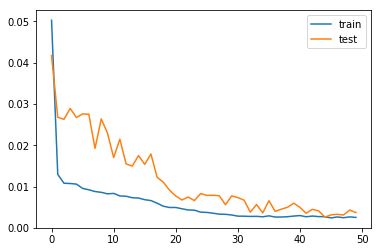

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
yhat = model.predict(test_X)
yhat

array([[ 0.94148958],
       [ 0.94241881],
       [ 0.9438988 ],
       ..., 
       [ 0.93700433],
       [ 0.93745804],
       [ 0.9386574 ]], dtype=float32)

In [17]:
maxT_in = max(testing_data['t_in'])
maxT_in

77.299999999999997

In [18]:
inv_yhat = np.array([])
for y in yhat:
    inv_yhat = np.append(inv_yhat, y*maxT_in)
inv_yhat

array([ 72.77714539,  72.84897614,  72.96337891, ...,  72.43043518,
        72.46550751,  72.55821991])

In [19]:
inv_y = np.array([])
for y in test_y:
    inv_y = np.append(inv_y, y*maxT_in)
inv_y

array([ 72.99999694,  72.99999694,  72.99999694, ...,  72.39999779,
        72.49999765,  72.49999765])

In [20]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.824


In [21]:
def forecasting(testX_df, testY_df, start_time, duration, model, maxT_in):
    predictions_i = []
    errs_i = []
    curr_time = start_time
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in testX_df.index:
            #print("Not present")
            return None
        input_x = testX_df.loc[curr_time].copy()
        if len(predictions_i) < 2:
            predictions_i.append(input_x['t_in'])
        else:
            input_x['t_in'] = predictions_i[-1]
            input_x['t_in(t-1)'] = predictions_i[-2]
        inputX_values = input_x.values
        inputX_values = inputX_values.reshape(1,2,5)
        y = model.predict([inputX_values])
        predictions_i.append(y[0])
        errs_i.append(testY_df.loc[curr_time]*maxT_in - y[0]*maxT_in)
        curr_time = curr_time + datetime.timedelta(minutes=5)
    #print(predictions_i)
    #print(errs_i)
    return errs_i

In [22]:
predictions = []
errs = []
startSamples = testX_df.sample(n=800)
startList = startSamples.index
duration = 60 * 7
for start in startList:
    errs_i = forecasting(testX_df, testY_df, start, duration, model, maxT_in)
    #predictions.append(pd.Series(index=range(len(predictions_i)), data=predictions_i))
    if errs_i:
        errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
#print(predictions)
#print(errs)

[0.3843171406786424, 0.5276395279331488, 0.7840518630198826, 0.9667566480350012, 1.1621943005994106, 1.316213026123495, 1.4812847097499642, 1.635838804463712, 1.7839567288039615, 1.9214699453961173, 2.060181463345429, 2.1977819598507984, 2.3113449231325633, 2.4168481444826737, 2.5118052999255496, 2.6138699392869205, 2.7204412823509845, 2.815437178347823, 2.9057523653278867, 2.9950747559565984, 3.0847848450889352, 3.1734808247604622, 3.2636691879979636, 3.340189847842904, 3.399347771603977, 3.4691755857993503, 3.536951587624868, 3.5985039456078534, 3.6635464668705118, 3.7288613686712484, 3.792378119517486, 3.852759868454918, 3.915770826354055, 3.9627915541515333, 4.003369574718992, 4.054033620622652, 4.106827572290644, 4.153923368266477, 4.191491786266936, 4.221836211302166, 4.251158588454515, 4.2828661571813225, 4.317959313973509, 4.345793085032271, 4.38595472944822, 4.420054917916597, 4.455619957587117, 4.484761204987616, 4.50874031507725, 4.532001719165931, 4.550988155959061, 4.56971

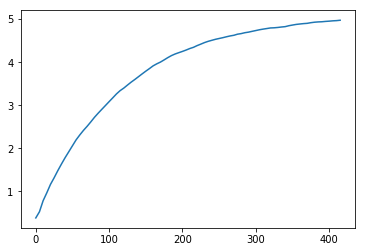

In [23]:
final_errors = []
for i in range(int(duration/5)):
    ei = np.array([])
    for e in errs:
        ei = np.append(ei, e.loc[i]*e.loc[i])
    final_errors.append(sqrt(np.mean(ei)))
#final_errors = pd.Series(index=range(len(final_errors)), data = final_errors)
print(final_errors)
timesteps = [x*5 for x in range(len(final_errors))]
plt.plot(timesteps,final_errors)
plt.show()